# ResNet18 Accident Intensity Classifier

This notebook creates a robust ResNet18 classifier to classify accident images as either "strong" or "weak" intensity.

## 1. Install Dependencies

First, install all required dependencies by running the following command in your terminal:

In [ ]:
%%bash
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install scikit-learn matplotlib seaborn pillow numpy jupyter

For CPU-only installation (if you don't have CUDA):

In [2]:
%%bash
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
pip install scikit-learn matplotlib seaborn pillow numpy jupyter

Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 0.0/68.6 MB ? eta -:--:--━━━━━━━━━━━━━━ 1.6/68.6 MB 10.5 MB/s eta 0:00:07━━━━━━━━━━━━━━━━━ 10.7/68.6 MB 30.0 MB/s eta 0:00:02━━━━━━━━━━━━━━━━━ 18.6/68.6 MB 33.2 MB/s eta 0:00:02━━━━━━━━━━━━━━━━━ 25.2/68.6 MB 32.9 MB/s eta 0:00:02━━━

  DEPRECATION: Building 'MarkupSafe' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'MarkupSafe'. Discussion can be found at https://github.com/pypa/pip/issues/6334


  Created wheel for MarkupSafe: filename=markupsafe-2.1.5-cp313-cp313-macosx_11_0_arm64.whl size=14002 sha256=935f4829ed9437e273e6bf432fa736a08cceb20b6f41cf3d73afd71ca8f80837
  Stored in directory: /Users/aslahyasar/Library/Caches/pip/wheels/84/b6/28/95b8e298901ee19b488797095efb5fbed28637ed83215b13b1
Successfully built MarkupSafe
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━m━━━━━━  0/12 [mpmath]━━━━━━━━━━━  0/12 [mpmath]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy]━━━━━━━━━━━━━━━━━  1/12 [sympy

## 2. Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.7.1
CUDA available: False


## 3. Custom Dataset Class

In [4]:
class AccidentDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## 4. Main Classifier Class

In [9]:
class AccidentClassifier:
    def __init__(self, data_dir="intensity_dataset", device=None):
        self.data_dir = data_dir
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.train_loader = None
        self.test_loader = None
        
        print(f"Using device: {self.device}")
        
        # Data augmentation and normalization for training
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Standard normalization for testing (no augmentation)
        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def load_data(self):
        """Load and split data into train/test sets"""
        # Load image paths and labels
        strong_images = glob.glob(os.path.join(self.data_dir, "strong", "*.jpg"))
        weak_images = glob.glob(os.path.join(self.data_dir, "weak", "*.jpg"))
        
        # Create labels (0 for weak, 1 for strong)
        image_paths = strong_images + weak_images
        labels = [1] * len(strong_images) + [0] * len(weak_images)
        
        print(f"Found {len(strong_images)} strong images and {len(weak_images)} weak images")
        print(f"Total images: {len(image_paths)}")
        
        if len(image_paths) == 0:
            raise ValueError(f"No images found in {self.data_dir}")
        
        # Stratified train-test split (80/20) to maintain class proportions
        train_paths, test_paths, train_labels, test_labels = train_test_split(
            image_paths, labels, test_size=0.2, random_state=42, stratify=labels
        )
        
        print(f"\nTrain set: {len(train_paths)} images")
        print(f"Test set: {len(test_paths)} images")
        print(f"Train - Strong: {sum(train_labels)}, Weak: {len(train_labels) - sum(train_labels)}")
        print(f"Test - Strong: {sum(test_labels)}, Weak: {len(test_labels) - sum(test_labels)}")
        
        # Create datasets
        train_dataset = AccidentDataset(train_paths, train_labels, self.train_transform)
        test_dataset = AccidentDataset(test_paths, test_labels, self.test_transform)
        
        # Create data loaders
        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
        self.test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
        
        return train_paths, test_paths, train_labels, test_labels
    
    def create_model(self):
        """Create ResNet18 model with custom classifier head"""
        # Load pre-trained ResNet18
        self.model = models.resnet18(pretrained=True)
        
        # Freeze early layers for transfer learning
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Replace final layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # 2 classes: weak (0), strong (1)
        )
        
        # Unfreeze last few layers for fine-tuning
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        for param in self.model.fc.parameters():
            param.requires_grad = True
        
        self.model = self.model.to(self.device)
        print("Model created and moved to device")
        
        # Print model summary
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
    
    def train(self, epochs=20, lr=0.001):
        """Train the model"""
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        train_losses = []
        train_accuracies = []
        
        print("Starting training...")
        print("-" * 50)
        
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for batch_idx, (images, labels) in enumerate(self.train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            scheduler.step()
            
            epoch_loss = running_loss / len(self.train_loader)
            epoch_acc = 100 * correct / total
            
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            
            print(f'Epoch [{epoch+1:2d}/{epochs}] | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%')
        
        print("-" * 50)
        print("Training completed!")
        
        return train_losses, train_accuracies
    
    def evaluate(self):
        """Evaluate the model on test set"""
        self.model.eval()
        all_predictions = []
        all_labels = []
        
        print("Evaluating model...")
        
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f'\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
        
        # Classification report
        class_names = ['Weak', 'Strong']
        print('\nClassification Report:')
        print(classification_report(all_labels, all_predictions, target_names=class_names))
        
        return accuracy, all_predictions, all_labels
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Weak', 'Strong'], yticklabels=['Weak', 'Strong'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def plot_training_curves(self, train_losses, train_accuracies):
        """Plot training loss and accuracy curves"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, 'b-', linewidth=2)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, 'r-', linewidth=2)
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath='accident_intensity_classifier.pth'):
        """Save the trained model"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'model_architecture': 'resnet18',
            'device': str(self.device)
        }, filepath)
        print(f'Model saved to {filepath}')
    
    def load_model(self, filepath='accident_intensity_classifier.pth'):
        """Load a saved model"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.create_model()
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        print(f'Model loaded from {filepath}')
    
    def predict_single_image(self, image_path):
        """Predict a single image"""
        if self.model is None:
            raise ValueError("Model not created or loaded. Call create_model() or load_model() first.")
        
        self.model.eval()
        
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.test_transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
        
        class_names = ['Weak', 'Strong']
        predicted_class = class_names[predicted.item()]
        confidence = probabilities[0][predicted.item()].item()
        
        return predicted_class, confidence

## 5. Initialize and Load Data

In [10]:
# Create classifier instance
classifier = AccidentClassifier(data_dir="intensity_dataset")

# Load and prepare data
train_paths, test_paths, train_labels, test_labels = classifier.load_data()

Using device: cpu
Found 423 strong images and 362 weak images
Total images: 785

Train set: 628 images
Test set: 157 images
Train - Strong: 338, Weak: 290
Test - Strong: 85, Weak: 72


## 6. Create Model

In [11]:
# Create the ResNet18 model
classifier.create_model()

Model created and moved to device
Total parameters: 11,242,434
Trainable parameters: 8,459,650


## 7. Train the Model

In [12]:
# Train the model
train_losses, train_accuracies = classifier.train(epochs=20, lr=0.001)

Starting training...
--------------------------------------------------
Epoch [ 1/20] | Loss: 0.5729 | Accuracy: 70.06%
Epoch [ 2/20] | Loss: 0.4084 | Accuracy: 81.53%
Epoch [ 3/20] | Loss: 0.3841 | Accuracy: 84.39%
Epoch [ 4/20] | Loss: 0.3241 | Accuracy: 88.69%
Epoch [ 5/20] | Loss: 0.3196 | Accuracy: 86.15%
Epoch [ 6/20] | Loss: 0.2965 | Accuracy: 87.26%
Epoch [ 7/20] | Loss: 0.3011 | Accuracy: 86.78%
Epoch [ 8/20] | Loss: 0.2470 | Accuracy: 89.33%
Epoch [ 9/20] | Loss: 0.2212 | Accuracy: 91.56%
Epoch [10/20] | Loss: 0.2190 | Accuracy: 90.76%
Epoch [11/20] | Loss: 0.2178 | Accuracy: 91.08%
Epoch [12/20] | Loss: 0.1881 | Accuracy: 92.52%
Epoch [13/20] | Loss: 0.1784 | Accuracy: 92.52%
Epoch [14/20] | Loss: 0.1859 | Accuracy: 91.88%
Epoch [15/20] | Loss: 0.1989 | Accuracy: 92.04%
Epoch [16/20] | Loss: 0.1655 | Accuracy: 93.47%
Epoch [17/20] | Loss: 0.1596 | Accuracy: 93.47%
Epoch [18/20] | Loss: 0.1523 | Accuracy: 93.47%
Epoch [19/20] | Loss: 0.1824 | Accuracy: 93.31%
Epoch [20/20] | 

## 8. Evaluate Model Performance

Evaluating model...

Test Accuracy: 0.8344 (83.44%)

Classification Report:
              precision    recall  f1-score   support

        Weak       0.81      0.83      0.82        72
      Strong       0.86      0.84      0.85        85

    accuracy                           0.83       157
   macro avg       0.83      0.83      0.83       157
weighted avg       0.83      0.83      0.83       157



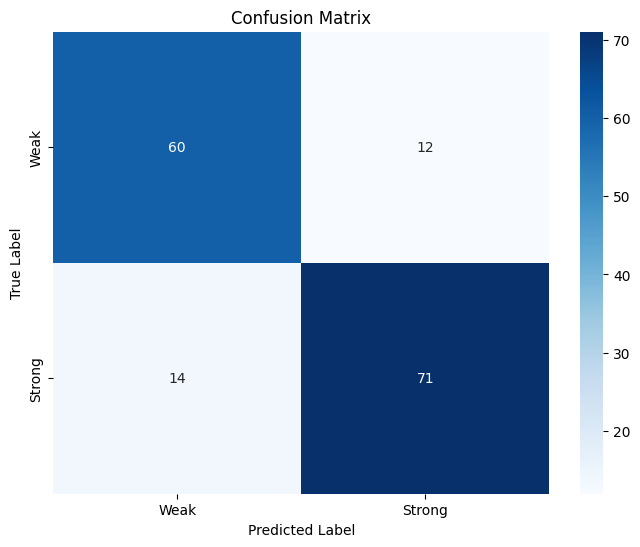

In [13]:
# Evaluate on test set
accuracy, predictions, labels = classifier.evaluate()

# Plot confusion matrix
classifier.plot_confusion_matrix(labels, predictions)

## 9. Visualize Training Progress

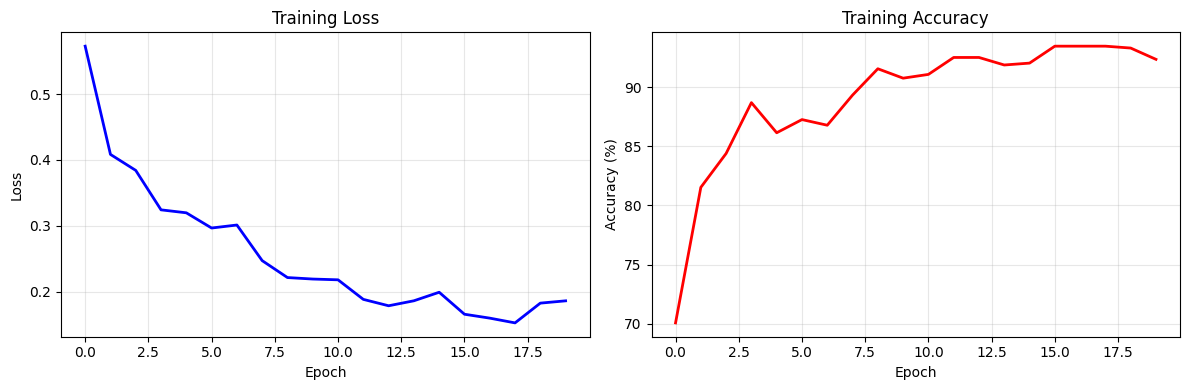

In [14]:
# Plot training curves
classifier.plot_training_curves(train_losses, train_accuracies)

## 10. Save the Model

In [15]:
# Save the trained model
classifier.save_model('accident_intensity_classifier.pth')

Model saved to accident_intensity_classifier.pth


## 11. Test Single Image Prediction

Image: test_test16_3_jpg.rf.81f0510b1103c621e08ae2d09449ac8a_0.jpg
Prediction: Strong
Confidence: 1.0000


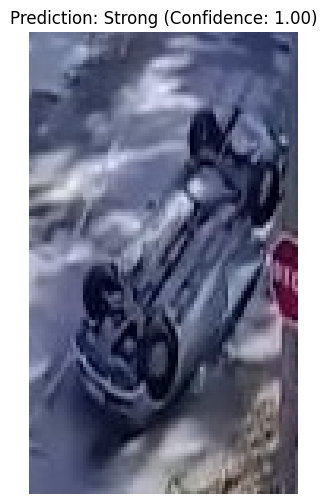

In [16]:
# Example: Predict a single image
# Replace 'path/to/your/image.jpg' with an actual image path from your test set
try:
    # Get a random test image for demonstration
    test_image_path = test_paths[0]  # First test image
    prediction, confidence = classifier.predict_single_image(test_image_path)
    
    print(f"Image: {os.path.basename(test_image_path)}")
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence:.4f}")
    
    # Display the image
    img = Image.open(test_image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {prediction} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()
    
except Exception as e:
    print(f"Error predicting image: {e}")
    print("Make sure you have images in your test set and the model is trained.")

## 12. Load Model for Future Use

In [ ]:
# To load a saved model in the future:
# classifier_new = AccidentClassifier()
# classifier_new.load_model('accident_intensity_classifier.pth')
# prediction, confidence = classifier_new.predict_single_image('path/to/image.jpg')

## Model Features Summary

**Robustness Features:**
- **Data Augmentation**: Horizontal flipping, rotation, color jittering, affine transformations
- **Transfer Learning**: Pre-trained ResNet18 weights from ImageNet
- **Fine-tuning**: Last layer block (layer4) unfrozen for domain adaptation
- **Regularization**: Dropout layers and weight decay
- **Learning Rate Scheduling**: Reduces learning rate during training

**Data Handling:**
- **Stratified Split**: Maintains class proportions in train/test sets (80/20)
- **Balanced Evaluation**: Comprehensive metrics including precision, recall, F1-score
- **Visualization**: Confusion matrix and training curves

**Model Architecture:**
- **Base**: ResNet18 with ImageNet pre-trained weights
- **Classifier Head**: Custom layers with dropout for binary classification
- **Output**: 2 classes (Weak=0, Strong=1)

This classifier is designed to be robust and generalize well to new accident images while maintaining high accuracy on the classification task.